# Flann usage applied to AKAZE, ORB and SIFT descriptors

In [4]:
from src.utils import image_utils
from src.utils import notebook_utils

from src.process import feature_extraction
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable



def LowesRatio(matches : list[cv.DMatch]) -> list[cv.DMatch]:
    goodMatches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance: 
            goodMatches.append(m)

    return goodMatches


icPictures = image_utils.load_raw_images("FotosICMural")
img1 = cv.cvtColor(icPictures["1"], cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(icPictures["2"], cv.COLOR_BGR2RGB)

FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH,
                    table_number=12,   # 12 is recommended
                    key_size=20,       # 20 is recommended
                    multi_probe_level=2) # 2 is recommended
search_params = dict(checks=50)  # How many times the trees are recursively traversed

# Create the FLANN matcher
flannMatcher = cv.FlannBasedMatcher(index_params, search_params)


In [5]:
def applyFlann(featExtractionMethod: Callable, flann: cv.FlannBasedMatcher):
    kp1, des1 = featExtractionMethod(img1)
    kp2, des2 = featExtractionMethod(img2)

    matches = flannMatcher.knnMatch(des1, des2, k=2) # Find matches with images descriptor, the k=2 argument defines the 2 best matches
    goodMatches = LowesRatio(matches)

    res = cv.drawMatches(img1, kp1, img2, kp2, goodMatches, None, matchesThickness=2, flags=2)

    print(f"Matches:\t{len(matches)}\n" +
        f"GoodMatches:\t{len(goodMatches)}\n" +
        f"Ratio:\t{len(goodMatches)/len(matches)}\n"
        )
    
    plt.imshow(res)


Matches:	40295
GoodMatches:	5561
Ratio:	0.1380071969226951



ValueError: not enough values to unpack (expected 2, got 0)

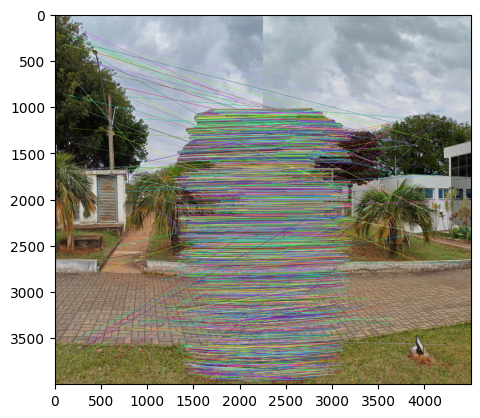

In [ ]:
#AKAZE
applyFlann(feature_extraction.AKAZE, flannMatcher)
#ORB
applyFlann(feature_extraction.ORB, flannMatcher)
#SIFT
applyFlann(feature_extraction.SIFT, flannMatcher)

#TODO diversify flann params and compare for report